<a href="https://colab.research.google.com/github/douglasmmachado/MedicineConsumption/blob/master/notebooks/unified_approach/5_Forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 5 - Forecasting and prediction



---



---



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
import math as m

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

from sklearn.tree import export_graphviz
from subprocess import call
from IPython.display import Image


df_url ="https://raw.githubusercontent.com/douglasmmachado/ExploratoryDataAnalysis/master/datasets/unified_approach/clustered/df_clustered.csv"

df = pd.read_csv(df_url)
df['YEAR'] = df['YEAR'].astype(int)
df['MONTH'] = df['MONTH'].astype(int)
df['DATE'] = pd.to_datetime(df['YEAR'].astype(str) + '-' + df['MONTH'].astype(str), format='%Y-%m')

In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 525 entries, 0 to 524
Data columns (total 18 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   CODE_ATC        525 non-null    int64         
 1   DATE            525 non-null    datetime64[ns]
 2   HOSPI_CODE_UCD  525 non-null    int64         
 3   LIT_HC          525 non-null    float64       
 4   LIT_HP          525 non-null    float64       
 5   MONTH           525 non-null    int64         
 6   N_UFS           525 non-null    float64       
 7   PN_MEDICAL      525 non-null    float64       
 8   POPULATION      525 non-null    float64       
 9   P_MEDICAL       525 non-null    float64       
 10  QUANTITY        525 non-null    float64       
 11  QUANTITY_MA     525 non-null    float64       
 12  SEJ_MCO         525 non-null    float64       
 13  SEJ_SLD         525 non-null    float64       
 14  SEJ_SSR         525 non-null    float64       
 15  WEEK  

## 5.1 - New database composition based on clusters

In [3]:
df_cluster_0 = df[df['CLUSTER'] == 0].copy()
df_cluster_1 = df[df['CLUSTER'] == 1].copy()
df_cluster_2 = df[df['CLUSTER'] == 2].copy()
df_cluster_3 = df[df['CLUSTER'] == 3].copy()

## 5.2 - Building forecasting models based on clusters

In [4]:
def plot_scatter(medicines, y_test, y_pred):
    plt.figure(figsize=(12, 6))
    plt.scatter(medicines, y_test, s=20, color='red', label='Test')
    plt.scatter(medicines, y_pred, s=20, color='blue', label='Pred')
    plt.xlabel('HOSPI_CODE_UCD')
    plt.ylabel('QUANTITY')
    plt.title(f'Scatter plot of ground truth and prediction per medicine')
    plt.xticks(rotation=90)
    plt.grid()
    plt.legend(title="Categories")
    plt.show()

In [5]:
def visualize_decision_tree(regr, feature_names, estimator_index = 5):
    estimator = regr.estimators_[estimator_index]

    # Export as dot file
    export_graphviz(estimator,
                    out_file='tree.dot',
                    feature_names=feature_names,
                    rounded=True,
                    precision=2,
                    filled=True)

    # Convert to png
    call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])

    # Display in Jupyter Notebook
    return Image(filename='tree.png')

### Hospital 1 - Cluster 0

Regression score: 0.99



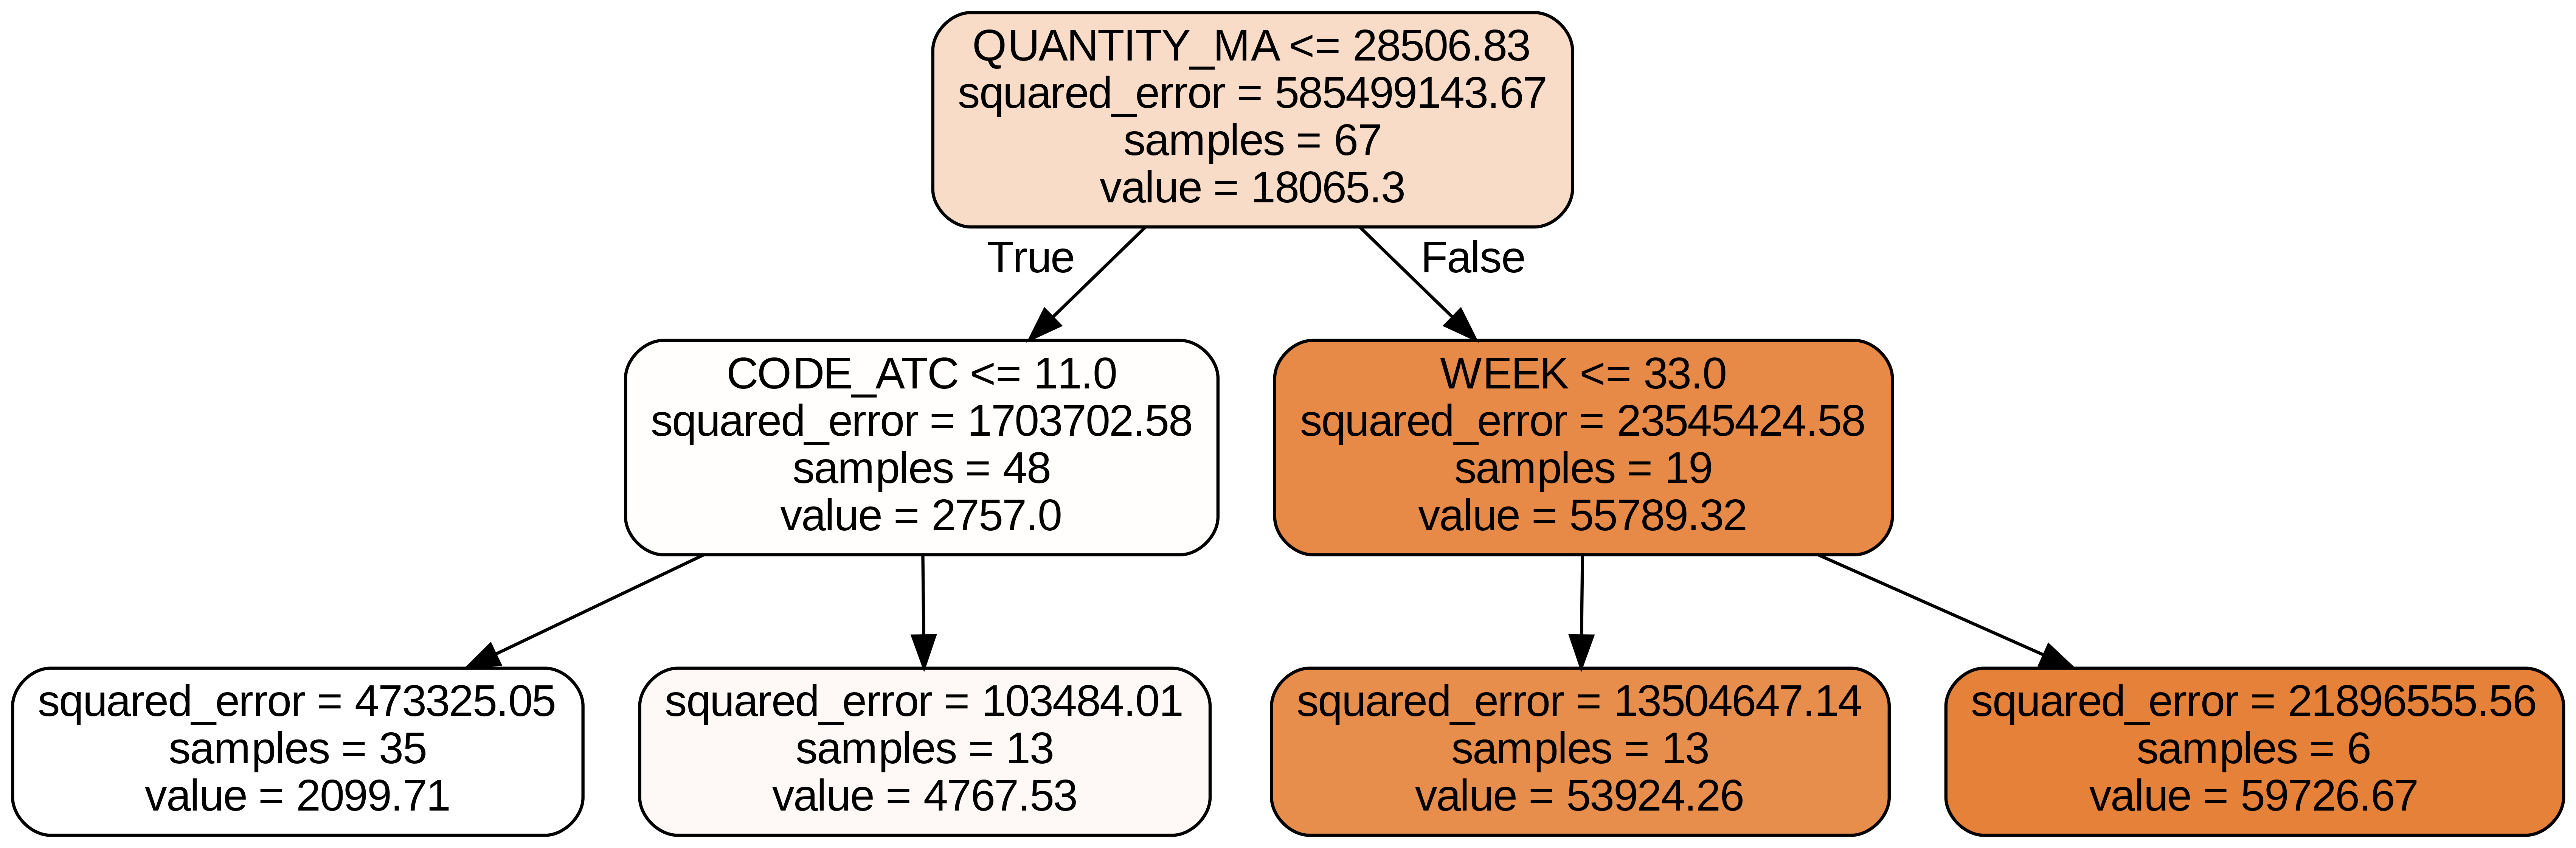

In [7]:
X = df_cluster_0.drop(['QUANTITY','DATE'],axis=1).copy().values
y = df_cluster_0["QUANTITY"].copy()

# Split the data into training and testing sets with a specific split size
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.35, shuffle=True)


regr = RandomForestRegressor(max_depth=2)
regr.fit(X_train, y_train)

print(f'Regression score: {regr.score(X_test, y_test):.2f}')
print()

feature_names = df_cluster_0.drop(['QUANTITY','DATE'],axis=1).copy().columns
visualize_decision_tree(regr, feature_names)

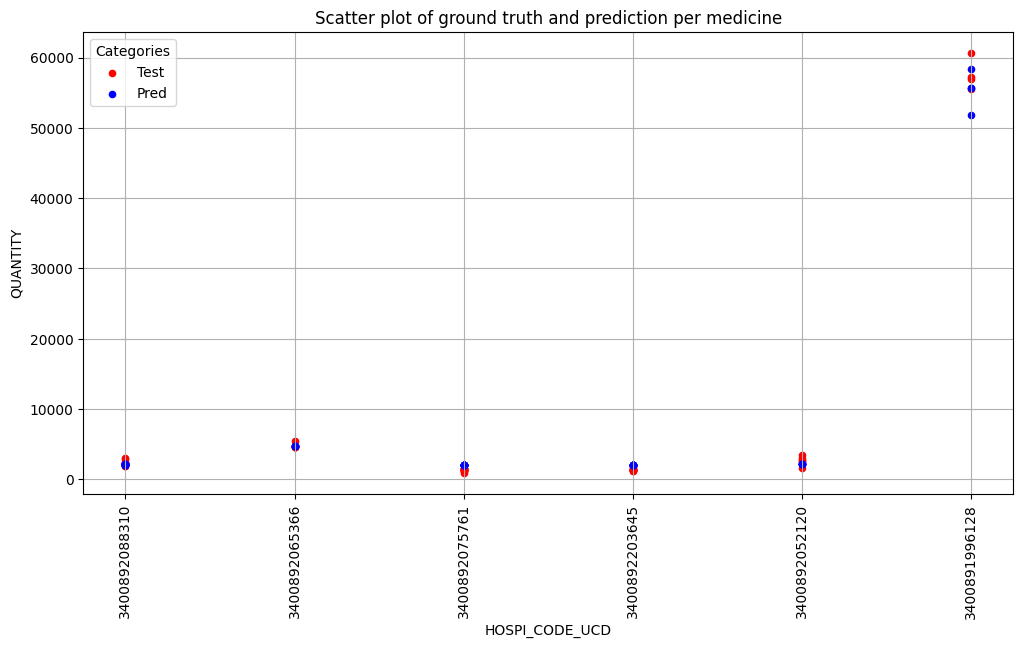

In [8]:
y_pred = regr.predict(X_test)

medicines = np.array(X_test[:,1])

# Convert elements to integers
medicines = medicines.astype(int)

# Convert elements to strings
medicines = medicines.astype(str)


plot_scatter(medicines, y_test, y_pred)

### Hospital 1 - Cluster 1


Regression score: 0.94



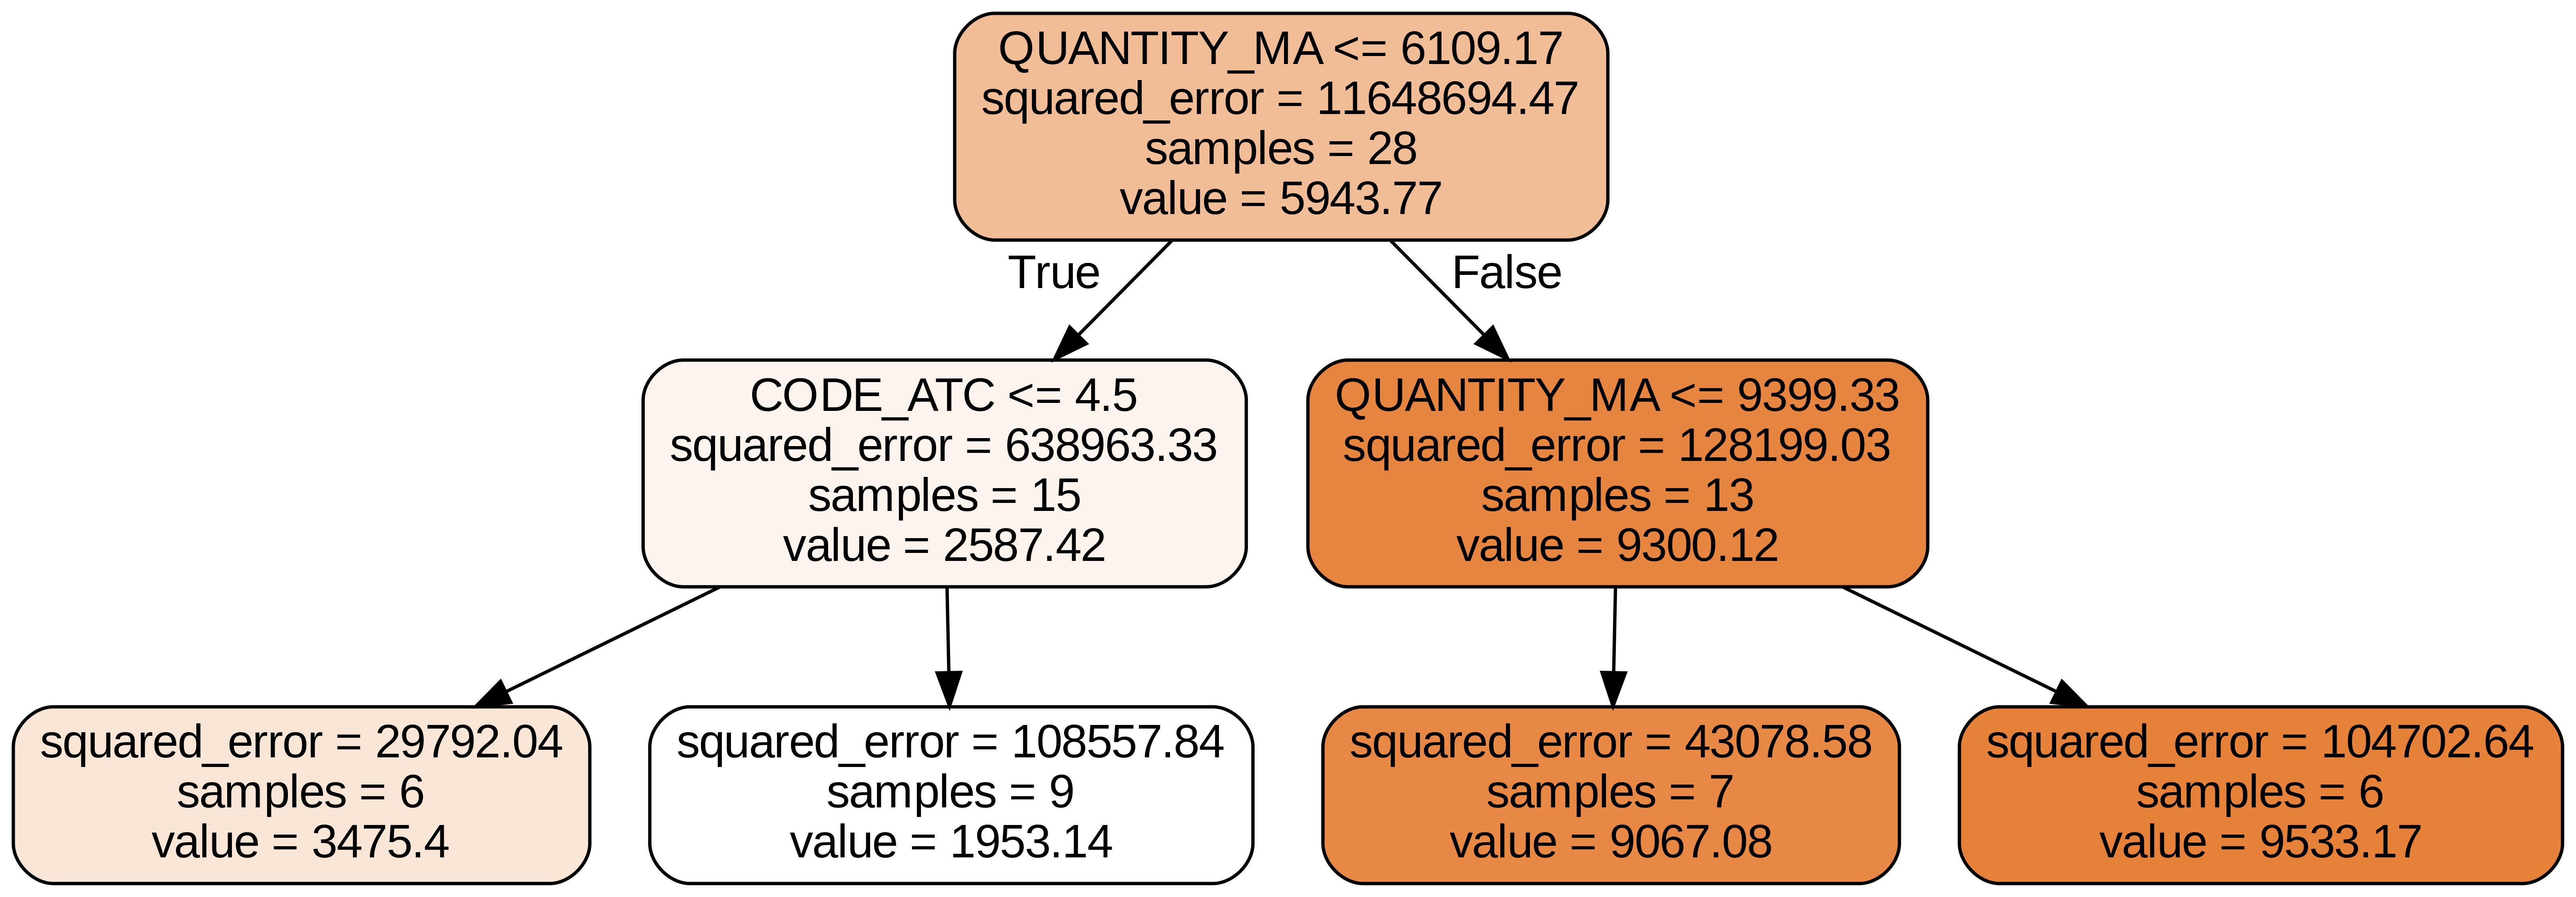

In [9]:
X = df_cluster_1.drop(['QUANTITY','DATE'],axis=1).copy().values
y = df_cluster_1["QUANTITY"].copy()

# Split the data into training and testing sets with a specific split size
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.35, shuffle=True)


regr = RandomForestRegressor(max_depth=2)
regr.fit(X_train, y_train)

print(f'Regression score: {regr.score(X_test, y_test):.2f}')
print()

feature_names = df_cluster_1.drop(['QUANTITY','DATE'],axis=1).copy().columns
visualize_decision_tree(regr, feature_names)

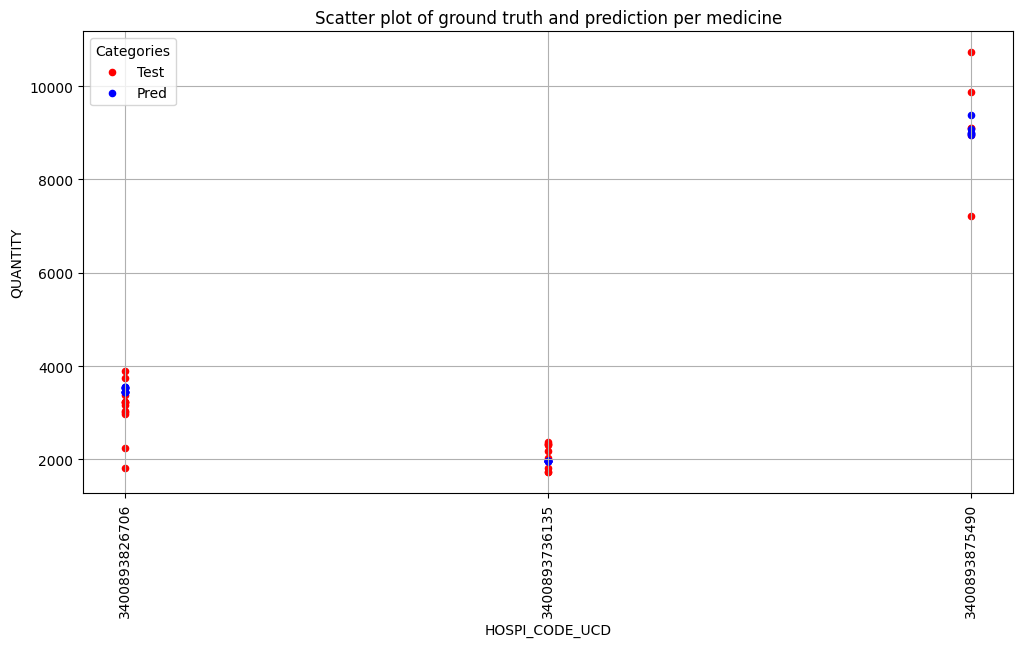

In [10]:
y_pred = regr.predict(X_test)

medicines = np.array(X_test[:,1])

# Convert elements to integers
medicines = medicines.astype(int)

# Convert elements to strings
medicines = medicines.astype(str)


plot_scatter(medicines, y_test, y_pred)

### Hospital 1 - Cluster 2

Regression score: 0.98



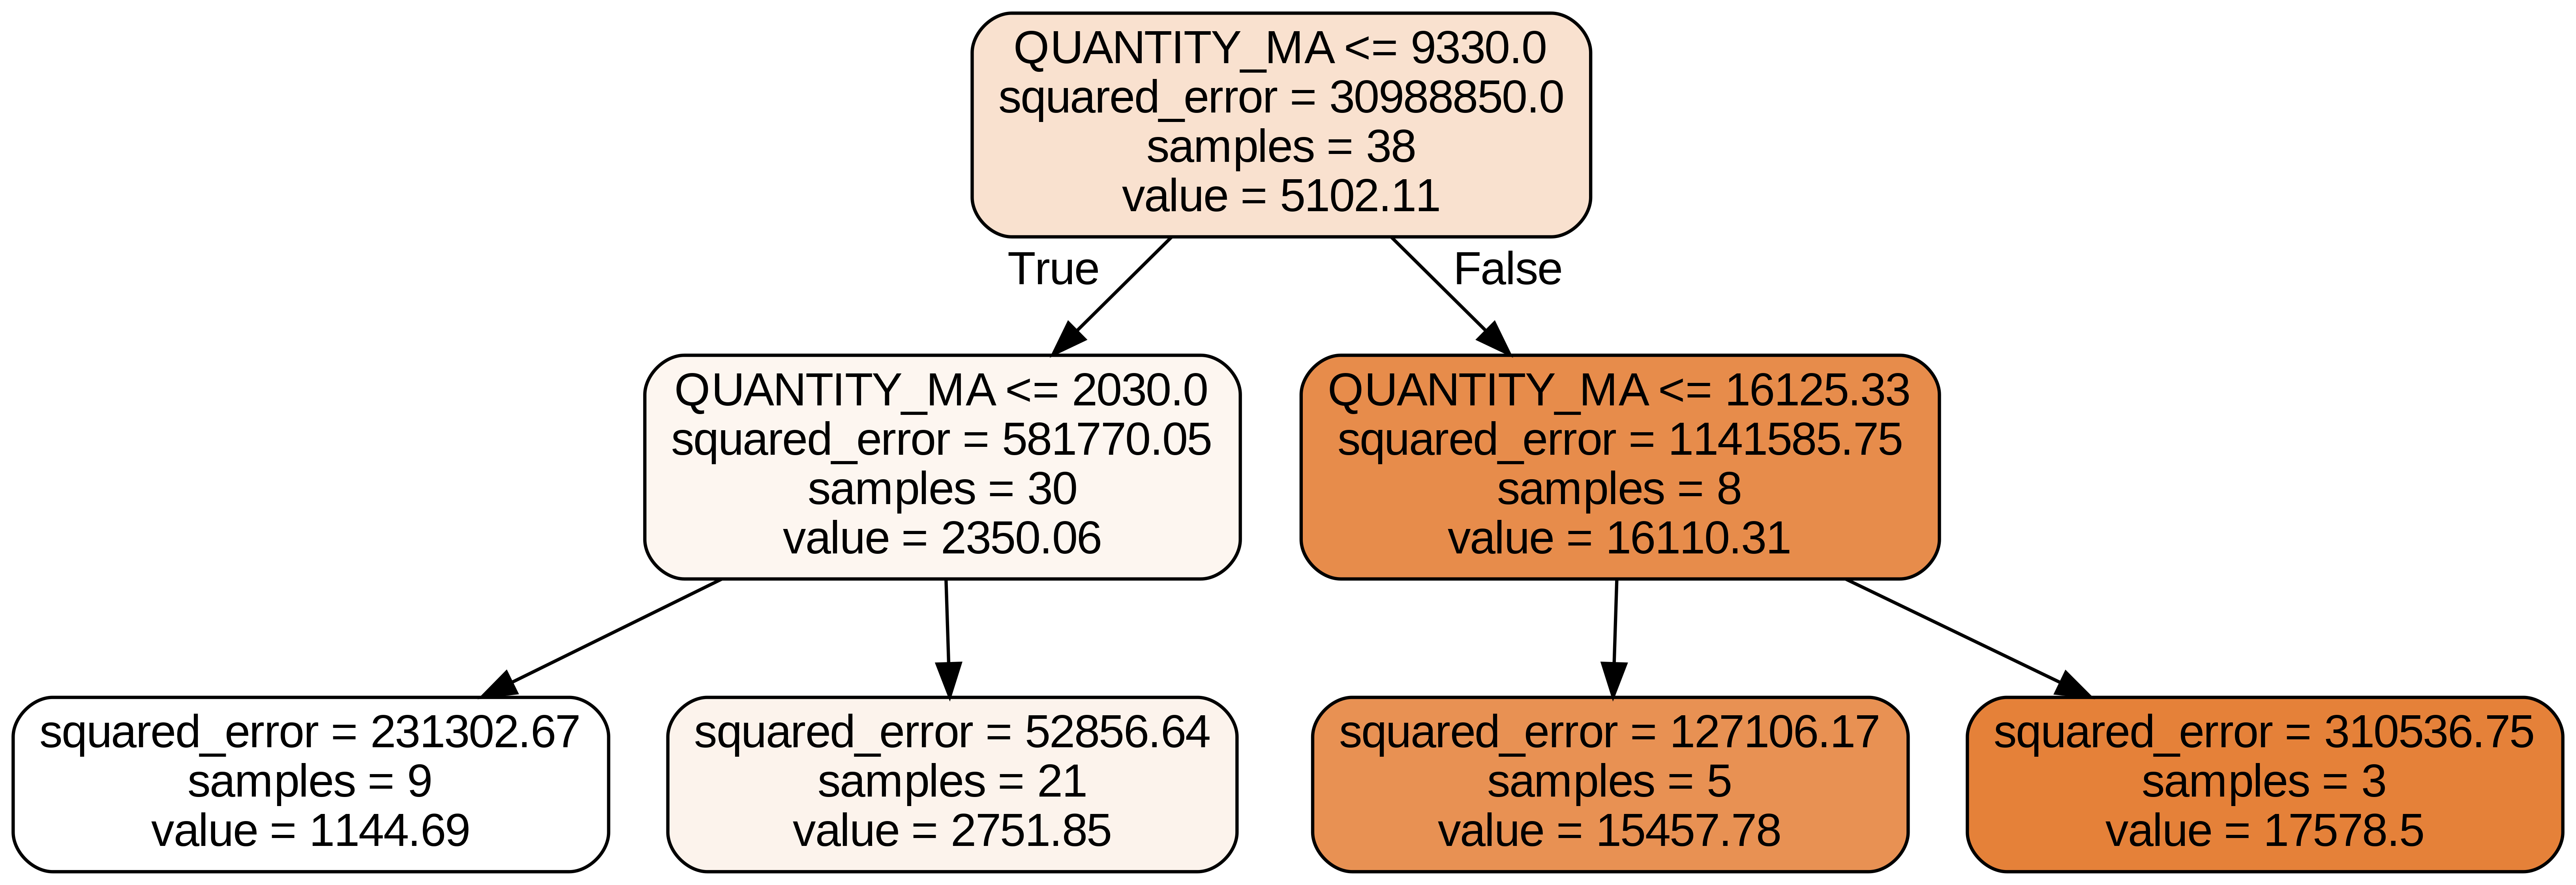

In [11]:
X = df_cluster_2.drop(['QUANTITY','DATE'],axis=1).copy().values
y = df_cluster_2["QUANTITY"].copy()

# Split the data into training and testing sets with a specific split size
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.35, shuffle=True)


regr = RandomForestRegressor(max_depth=2)
regr.fit(X_train, y_train)

print(f'Regression score: {regr.score(X_test, y_test):.2f}')
print()

feature_names = df_cluster_2.drop(['QUANTITY','DATE'],axis=1).copy().columns
visualize_decision_tree(regr, feature_names)

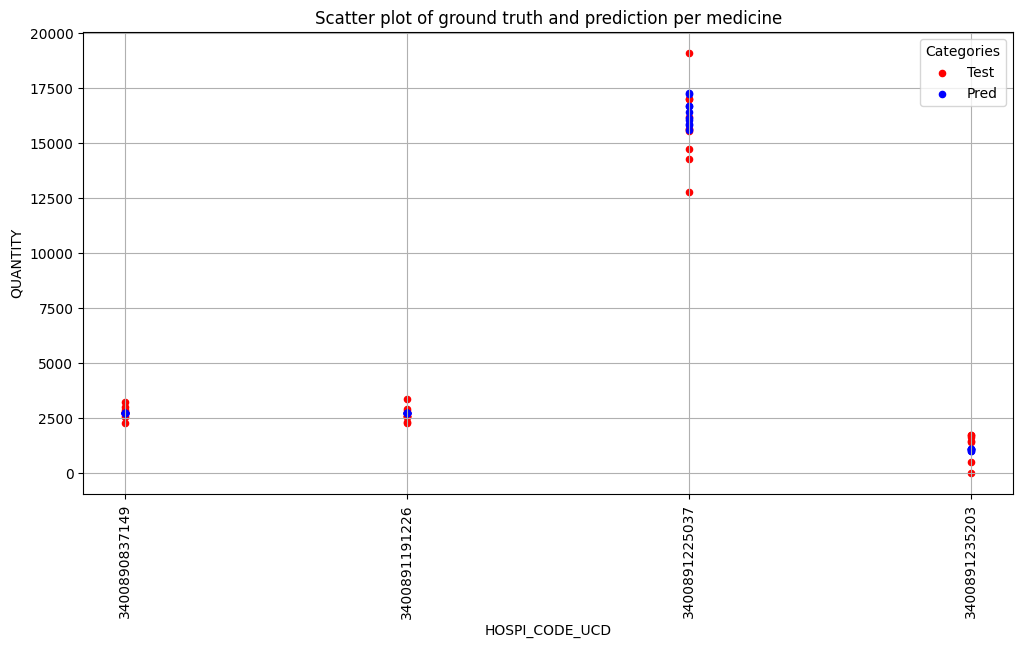

In [12]:
y_pred = regr.predict(X_test)

medicines = np.array(X_test[:,1])

# Convert elements to integers
medicines = medicines.astype(int)

# Convert elements to strings
medicines = medicines.astype(str)


plot_scatter(medicines, y_test, y_pred)

### Hospital 1 - Cluster 3

Regression score: 0.86



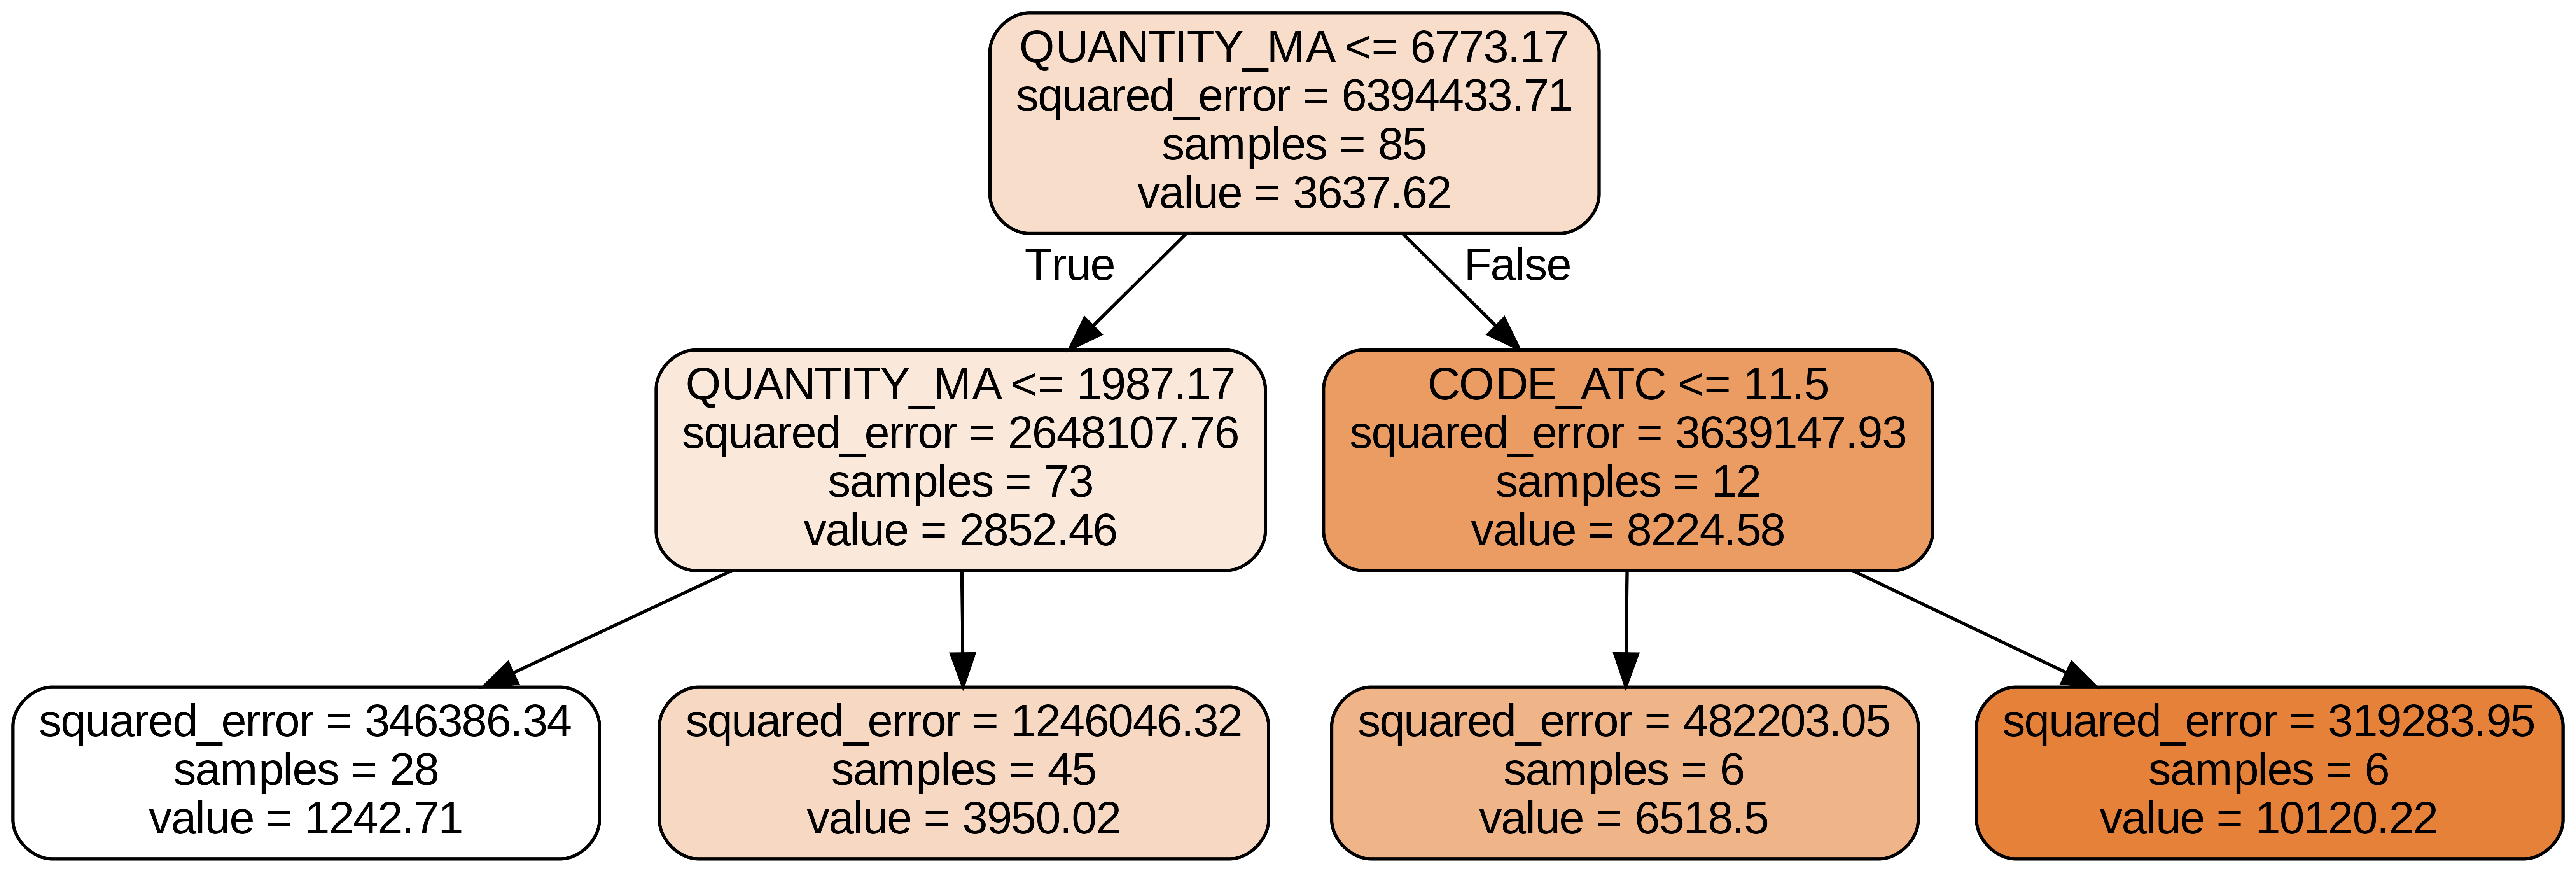

In [13]:
X = df_cluster_3.drop(['QUANTITY','DATE'],axis=1).copy().values
y = df_cluster_3["QUANTITY"].copy()

# Split the data into training and testing sets with a specific split size
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.35, shuffle=True)


regr = RandomForestRegressor(max_depth=2)
regr.fit(X_train, y_train)


print(f'Regression score: {regr.score(X_test, y_test):.2f}')
print()

feature_names = df_cluster_3.drop(['QUANTITY','DATE'],axis=1).copy().columns
visualize_decision_tree(regr, feature_names)

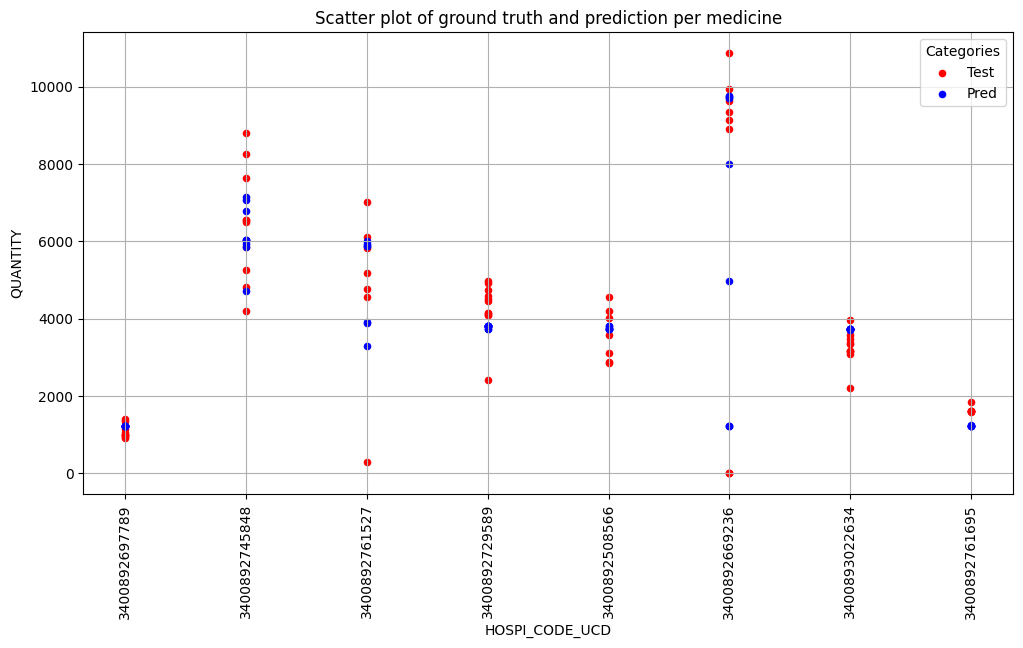

In [14]:
y_pred = regr.predict(X_test)

medicines = np.array(X_test[:,1])

# Convert elements to integers
medicines = medicines.astype(int)

# Convert elements to strings
medicines = medicines.astype(str)


plot_scatter(medicines, y_test, y_pred)